In [56]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import PredictionErrorDisplay

import lightgbm as lgb

In [57]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

In [58]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in A.columns]
B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in B.columns]
C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in C.columns]

In [59]:
obs_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_A.columns]
est_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_A.columns]
test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]

obs_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_B.columns]
est_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_B.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]

obs_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_C.columns]
est_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_C.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

A = A[A['date_forecast'].dt.month.isin([4, 5, 6, 7, 8, 9])]
unique_days = A['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

B = B[B['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = B['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
unique_days = C['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')


In [60]:
print(X_train_A.shape)
print(X_val_A.shape)

(13440, 15)
(3338, 15)


In [61]:

train_data_A = lgb.Dataset(X_train_A, label=y_train_A)
val_data_A = lgb.Dataset(X_val_A, label=y_val_A, reference=train_data_A)

train_data_B = lgb.Dataset(X_train_B, label=y_train_B)
val_data_B = lgb.Dataset(X_val_B, label=y_val_B, reference=train_data_B)

train_data_C = lgb.Dataset(X_train_C, label=y_train_C)
val_data_C = lgb.Dataset(X_val_C, label=y_val_C, reference=train_data_C)

# Set the parameters for the model
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

In [62]:
# Train the model (evaluation)
gbm_A = lgb.train(params,
                train_data_A,
                num_boost_round=500,
                valid_sets=[val_data_A],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_B = lgb.train(params,
                train_data_B,
                num_boost_round=500,
                valid_sets=[val_data_B],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_C = lgb.train(params,
                train_data_C,
                num_boost_round=500,
                valid_sets=[val_data_C],
                early_stopping_rounds=50,
                verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2646
[LightGBM] [Info] Number of data points in the train set: 13440, number of used features: 15
[LightGBM] [Info] Start training from score 1055.365944


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 440.447
[100]	valid_0's l1: 383.381
[150]	valid_0's l1: 365.998
[200]	valid_0's l1: 344.239
[250]	valid_0's l1: 337.765
[300]	valid_0's l1: 336.836
[350]	valid_0's l1: 336.492
[400]	valid_0's l1: 333.118
[450]	valid_0's l1: 331.543
[500]	valid_0's l1: 332.092
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2618
[LightGBM] [Info] Number of data points in the train set: 8269, number of used features: 15
[LightGBM] [Info] Start training from score 226.956201


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 93.8325
[100]	valid_0's l1: 83.3405
[150]	valid_0's l1: 78.151
[200]	valid_0's l1: 71.1622
[250]	valid_0's l1: 68.8336
[300]	valid_0's l1: 68.3559
[350]	valid_0's l1: 68.1446
[400]	valid_0's l1: 66.7083
[450]	valid_0's l1: 66.3629
[500]	valid_0's l1: 66.7433
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 6934, number of used features: 15
[LightGBM] [Info] Start training from score 182.787808


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 72.5324
[100]	valid_0's l1: 63.2078
[150]	valid_0's l1: 60.0107
[200]	valid_0's l1: 55.9972
[250]	valid_0's l1: 54.764
[300]	valid_0's l1: 54.2751
[350]	valid_0's l1: 53.9134
[400]	valid_0's l1: 53.6287
[450]	valid_0's l1: 53.5218
[500]	valid_0's l1: 53.5662


In [63]:
# Train the model (submission)

# params = {
#     'boosting_type': 'dart',
#     'objective': 'regression',
#     'metric': 'mae',
#     'num_leaves': 100,
#     'learning_rate': 0.05,
#     'verbose': 1
# }

# A = lgb.Dataset(X_A, label=y_A)
# B = lgb.Dataset(X_B, label=y_B)
# C = lgb.Dataset(X_C, label=y_C)


# gbm_A = lgb.train(params,
#                 A,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

# gbm_B = lgb.train(params,
#                 B,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

# gbm_C = lgb.train(params,
#                 C,
#                 num_boost_round=350,
#                 early_stopping_rounds=50,
#                 verbose_eval=50)

In [64]:
# Evaluate the model
y_pred_A = gbm_A.predict(X_val_A, num_iteration=gbm_A.best_iteration)
y_pred_B = gbm_B.predict(X_val_B, num_iteration=gbm_B.best_iteration)
y_pred_C = gbm_C.predict(X_val_C, num_iteration=gbm_C.best_iteration)

print('MAE A:', mean_absolute_error(y_val_A, y_pred_A))
print('MAE B:', mean_absolute_error(y_val_B, y_pred_B))
print('MAE C:', mean_absolute_error(y_val_C, y_pred_C))
print('MAE:', (mean_absolute_error(y_val_A, y_pred_A) + mean_absolute_error(y_val_B, y_pred_B) + mean_absolute_error(y_val_C, y_pred_C)) / 3)

print('ME A: ', np.mean(y_val_A - y_pred_A))
print('ME B: ', np.mean(y_val_B - y_pred_B))
print('ME C: ', np.mean(y_val_C - y_pred_C))
print('Total ME:', (np.mean(y_val_A - y_pred_A) + np.mean(y_val_B - y_pred_B) + np.mean(y_val_C - y_pred_C))/3)

# MAE A: 331.2696740617782
# MAE B: 70.54419575660165
# MAE C: 53.55364544369583
# MAE: 151.7891717540252
# ME A:  -2.4204579401772617
# ME B:  -1.2782073874974178
# ME C:  -0.35264770642493254
# Total ME: -1.3504376780332041

# MAE A: 316.44796484965883
# MAE B: 64.15145793069622
# MAE C: 47.91948736603014
# MAE: 142.83963671546172
# ME A:  13.847525673309592
# ME B:  5.54613300090162
# ME C:  16.869539192742234
# Total ME: 12.087732622317816

# MAE A: 324.1150592319418
# MAE B: 59.619066123856825
# MAE C: 45.38976628547951
# MAE: 143.0412972137594
# ME A:  -7.986712974667452
# ME B:  9.42957244715977
# ME C:  5.27097267392453
# Total ME: 2.237944048805616

# MAE A: 332.0920422459656
# MAE B: 66.74326494967254
# MAE C: 53.56622083252486
# MAE: 150.80050934272103
# ME A:  4.807672653576304
# ME B:  14.69415737543642
# ME C:  0.48739694693299823
# Total ME: 6.663075658648574

MAE A: 332.0920422459656
MAE B: 66.74326494967254
MAE C: 53.56622083252486
MAE: 150.80050934272103
ME A:  4.807672653576304
ME B:  14.69415737543642
ME C:  0.48739694693299823
Total ME: 6.663075658648574


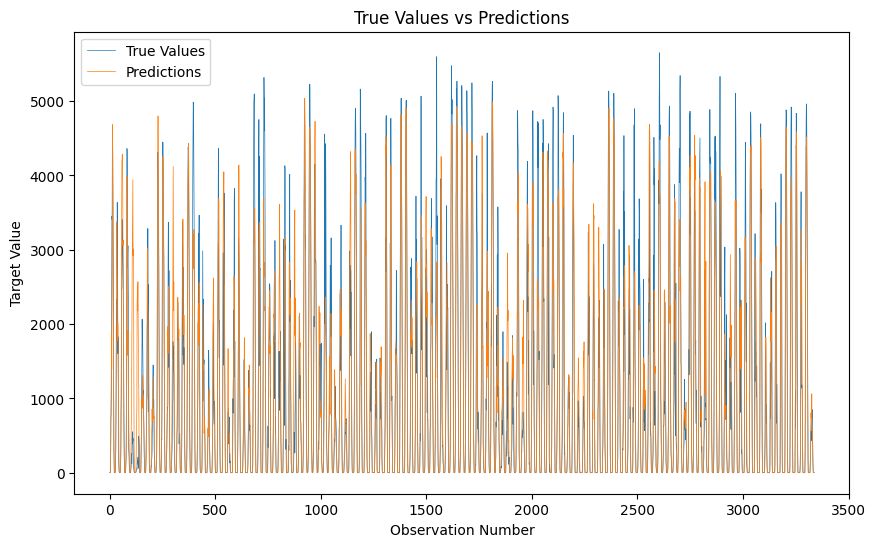

In [65]:
y_pred_A_test = gbm_A.predict(X_val_A)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val_A.reset_index(drop=True), label='True Values', linewidth=0.5)
plt.plot(y_pred_A_test, label='Predictions', linewidth=0.5)
plt.title('True Values vs Predictions')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.savefig('true_vs_pred.png')
plt.show()

In [66]:
test_A.describe()

,total_radiationW,total_radiation_1hJ,snow_accumulation,super_cooled_liquid_waterkgm2,average_wind_speed,sun_elevationd,sun_azimuthd,clear_sky_radW,month,t_1000hPaC,msl_pressurehPa_scaled,rain_waterkgm2,cloud_base_aglm,effective_cloud_coverp,dew_or_rimeidx
count,720.000000,7.200000e+02,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,798.736084,7.190753e+05,0.006250,0.255694,2.407205,20.293596,183.167038,1364.056030,5.666667,11.573374,0.707816,0.053333,1840.514282,256.529175,0.029167
std,860.062622,7.675138e+05,0.119234,0.435166,2.079982,18.681122,109.241638,1227.647705,0.596699,5.811303,0.223836,0.209417,2237.794678,149.477417,0.168390
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-11.579000,8.272000,0.000000,5.000000,0.649994,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.275001,3.855890e+04,0.000000,0.000000,0.509375,1.984250,85.375000,71.800001,5.000000,6.699982,0.587120,0.000000,453.600006,130.700005,0.000000
50%,487.499985,4.549644e+05,0.000000,0.000000,1.993750,18.545500,184.235504,1198.300049,6.000000,11.625000,0.791547,0.000000,942.800018,307.500000,0.000000
75%,1373.349976,1.196283e+06,0.000000,0.400000,3.840625,38.090500,279.566498,2646.949951,6.000000,15.025002,0.870041,0.000000,2397.724915,399.799988,0.000000
max,3059.699951,2.745778e+06,2.500000,2.400000,9.062500,49.863998,356.983002,3339.800049,7.000000,28.800018,1.000000,2.100000,11256.700195,400.000000,1.000000


In [67]:
# Create submission

output_file = 'LGBM_submission.csv'

pred_A = gbm_A.predict(test_A)
pred_B = gbm_B.predict(test_B)
pred_C = gbm_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to LGBM_submission.csv


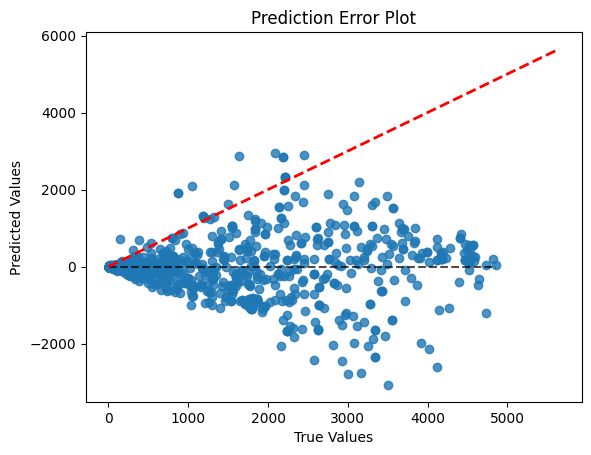

In [68]:

pred_A = gbm_A.predict(X_val_A)
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_val_A, pred_A, ax=ax)
ax.plot([y_val_A.min(), y_val_A.max()], [y_val_A.min(), y_val_A.max()], '--r', linewidth=2)
ax.set_title('Prediction Error Plot')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.show()

In [69]:
gbm_A.params

{'boosting_type': 'dart',
 'objective': 'regression',
 'metric': 'mae',
 'num_leaves': 100,
 'learning_rate': 0.05,
 'verbose': 1,
 'num_iterations': 500,
 'early_stopping_round': 50}